# Extra Notebook 2. Count objects

This Notebook is responsible for:
- reading in a whole dataset with object detections from a parquet file
- splitting the dataset by object (person, cat, dog, car etc.)
- compressing multiple observations of the same object into a single image
- saving an output for Person and Vehicle classes as individual parquet datasets

Counting events using data can get very complicated, as it is determined by humans and what do they thing a single count should be.

This is a serious challenge in the analytics space. As an example lets take counting calls in the Call Center.

What contributes to a single call? Is it a unique person calling with a unique issue? What if the same person calls twice within  minutes? Or what if the call gets disconnected and the same person reaches another agent? Or what if there is a glitch in the system and calls are merged?

It is very easy to get bogged down with many questions and details, however very often the most simple solution is the best solution.

With this in mind, we can proceed to counting objects in the dataset imported below.

In [2]:
# import ConfigImports Notebook to import and configure libs
%run ../Config/ConfigImports.ipynb

TF -> Using GPU ->  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load dataset

Raw images with the detections were preprocessed in the [ExtractRawImageData Notebook](./ExtractRawImageData.ipynb).

Each detection was saved as individual record and then all this data was saves in a compressed .parquet file (very efficient and modern way of data storage for large datasets).

It contains over 600K+ records:

In [3]:
df = pd.read_parquet('../Datasets/AllObjectDetections_2019-09-09_2020-03-02.parquet.gzip')
df = df.drop(labels=['index'], axis=1)
df.head(2)

,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min
0,72846,car,0.523175,298,7,426,71,2019-09-09,07.02.40,07.02.40.270_34c99836_car-car-car.jpg,1,270,2019-09-09 07:02:40.270,Monday,False,9,7,2
1,72847,person,0.759682,489,31,518,106,2019-09-09,12.02.42,12.02.42.921_ea6c9143_person-bicycle.jpg,2,921,2019-09-09 12:02:42.921,Monday,False,9,12,2


**Data definition:**
- img_idx - index of image
- label - detected object type
- confidence - metric returned by the object detector, the lower it is, the more probability the detection is incorrect
- x1,y1,x2,y2 - x,y coordinates of object detected in the image
- date, time - date and time of the detection
- filename - original image filename
- img_n_boxes - how many objects were detected in this particular image
- date_time - more precise date time (with mili seconds)
- week_day ... min - calendar information related to date_time column

## Remove erroneous data

During the data collection, a three days of data were lost due to loss of power:

Power outages:
- 2020-01-13
- 2020-01-14

Contractors onsite:
- 2020-02-28

There might have been some random images captured during that time, so this data is considered bad and it should be removed from the dataset.

In [4]:
idx = df['date'].isin(CONFIG['DOWNTIME_DATES'])
df = df.loc[~idx]

## Verify class distribution

The dataset represents the environment, so it must be skewed towards certain classes.

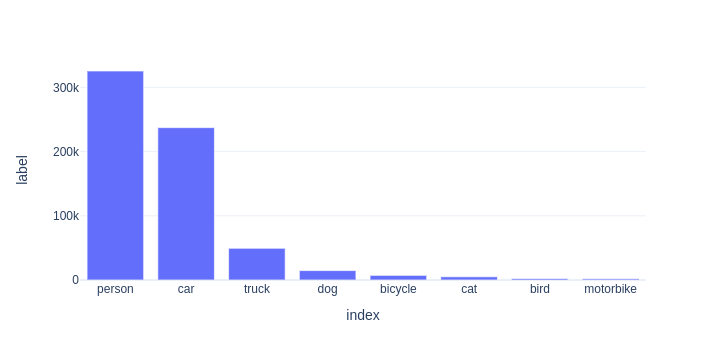

In [5]:
v_counts = df['label'].value_counts().reset_index()
px.bar(v_counts, y='label', x='index', height=300, width=500)

People and vehicles represent the vast majority of the dataset and they will be the focus of this research. The other classes are very sporadic and too random to predict with any certainty.

Instead of treating cars and trucks as two separate classes, they can be joined into a single class: *vehicle*:

In [6]:
idx = df['label'].isin(['car', 'truck'])
df.loc[idx, 'label'] = 'vehicle'

Now the vehicle class contains both object types: car and truck.

## Object counting

The main objective of this Notebook is to search for sequences of frames representing single events and pick only a single frame from each sequence:
<p style="text-align: center; margin-bottom: 0;">Fig. Ext. 2.1 Sequence of frames</p>
<img src="../Resources/img/moving-object.png" style="width: 90%;"/>

<p style="text-align: center; margin-bottom: 0;">Fig. Ext. 2.2 Single frame</p>
<img src="../Resources/img/single-frame-from-seq.png" style="width: 60%;"/>

The approach taken below is simple and works well for a dataset with a low number of objects:
- sort data by time
- divide dataset by object type (label) and perform following tasks:
    - iterate through all frames containing one class (like Person or Car)
    - calculate difference in time between consecutive object observations
    - use $x,y$ coordinates to calculate **euclidean distance** between object centroids in consecutive frames, if it's the same observation in a sequence, then the center will be close to the previous center
    - keep only objects where the difference in time and distance are greater than the predefined thresholds (these have been set using heuristics and might change depending on the camera and its location)
    
Eucledian distance is a good distance metric as it is the most common and simple measure of measuring the distance between $N$ points in $N$-dimensional space.

As defined in [iq.opengenus.org](https://iq.opengenus.org/euclidean-distance/):
Euclidean distance is the shortest distance between two points in an $N$ dimensional space also known as Euclidean space. It is used as a common metric to measure the similarity between two data points and used in various fields such as geometry, data mining, deep learning and others.

It is also, known as Euclidean norm, Euclidean metric, L2 norm, L2 metric and Pythagorean metric.

$$
d= \sqrt{(x1-x2)^2+(y1-y2)^2}
$$

The algorithm above works well with the following threshold parameters:
- `THRESH_NEW_EVENT_SECS=10` - time after which we treat another observation as unique count
- `THRESH_NEW_EVENT_MIN_DISTANCE=30` - distance in pixels between centroids

In [11]:
# dictionary to hold a dataframe per detected object class
dfs = {}

In [12]:
# these values seem to reject duplicates the best
THRESH_NEW_EVENT_SECS = 10  # how many seconds needs to elapse until we treat detection as a new observation
THRESH_NEW_EVENT_MIN_DISTANCE = 30  # min distance between 2 detections until we treat it as a new observation

In [13]:
# use this function to calculate euclidean distance between coordinates
def calc_distance(x):
    x_cur, y_cur, x_prev, y_prev = x
    return dist.cdist([[x_cur, y_cur]], [[x_prev, y_prev]], metric='euclidean')[0][0]

In [14]:
# sort observations chronologically
df = df.sort_values('date_time', ascending=True)

# create a separate DataFrame for each label of interest and save as a csv file
for l in ['vehicle', 'person']:
    
    print('Processing label: {}'.format(l))
    
    # filter out other objects from the data frame
    analysed_label_df = df.loc[df['label'].isin([l])].reset_index(drop=True).copy()
    
    # add a dummy variable, which we can use to count objects, there are most likely
    # better ways of doing this, but this one is simple and it works
    analysed_label_df['dummy_var'] = 1
    
    # calculate time difference between consecutive rows
    analysed_label_df['time_diff'] = analysed_label_df['date_time'].diff().fillna(pd.Timedelta(seconds=0))
    analysed_label_df['sec_diff'] = analysed_label_df['time_diff'].dt.total_seconds().fillna(0)
    analysed_label_df['x_center'] = analysed_label_df[['x1', 'x2']].mean(axis=1)
    analysed_label_df['y_center'] = analysed_label_df[['y1', 'y2']].mean(axis=1)

    # calculate euclidian distance between consecutive centroids (using x,y coordinates centroids)
    analysed_label_df['prev_x_center'] = analysed_label_df['x_center'].shift(1).fillna(0)
    analysed_label_df['prev_y_center'] = analysed_label_df['y_center'].shift(1).fillna(0)
    analysed_label_df['euc_distance'] = analysed_label_df[['x_center', 'y_center', 
        'prev_x_center', 'prev_y_center']].apply(calc_distance, axis=1)

    # keep only records within the rejection threshold
    idx = ((analysed_label_df['sec_diff'] > THRESH_NEW_EVENT_SECS) & 
           (analysed_label_df['euc_distance'] > THRESH_NEW_EVENT_MIN_DISTANCE))
    dfs[l] = analysed_label_df.loc[idx].reset_index(drop=True).copy()
    dfs[l].to_csv(f'../Datasets/UniqueObjectDetections__{l}__2019-09-09_2020-03-02.csv', index=False)

Processing label: vehicle
Processing label: person
